# <center> <h1>US Traffic Fatality Records</h1> </center>
<center> <h1>Terrence Elijah White</h1> </center>
<center> <h1>SEIS 603 - Foundations of Software Development Python</h1> </center>


## Abstract
This project explores the US traffic fatality data made available by the Fatality Analysis Reporting System (FARS), which was created in the United States by the National Highway Traffic Safety Administration (NHTSA). The data was made available via a Kaggle competition and provides a broad assessment of highway safety. The data was collected and made freely available to help suggest solutions to the epidemic of highway fatalities. It also helps in the evaluation of the efficacy of motor vehicle safety standards and highway safety programs.

## Accessing the data
The data is accessible only via the BigQuery API. Kaggle requires the use of kernels (Jupyter notebooks on the Kaggle site) to access the data. Each table composing this dataset was extracted into a local .csv file using this method. What follows is a sample of the code used for extracting the “cevent” table.  This code was run for each table in the dataset. 

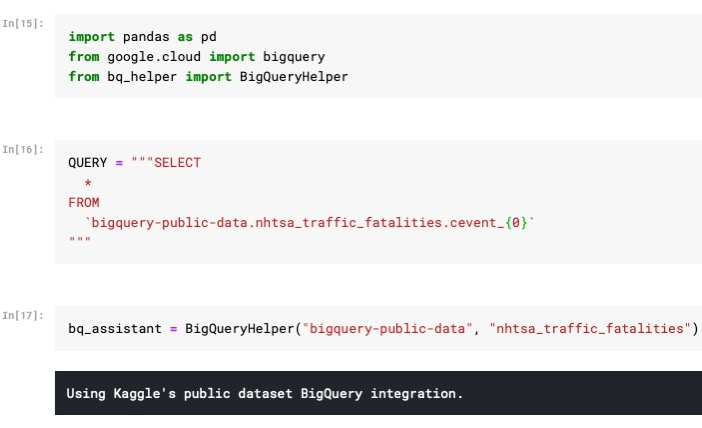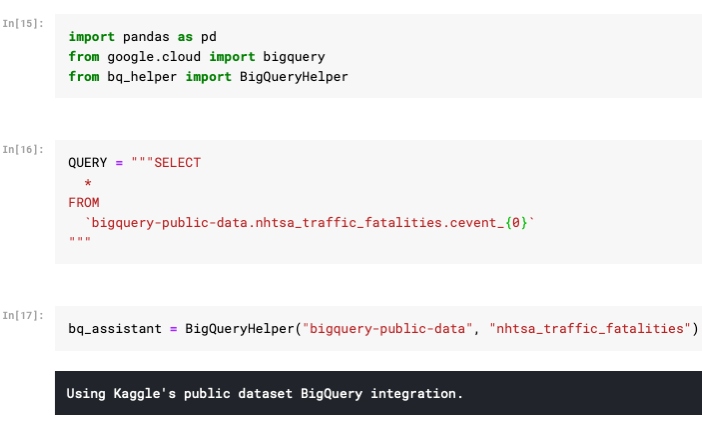

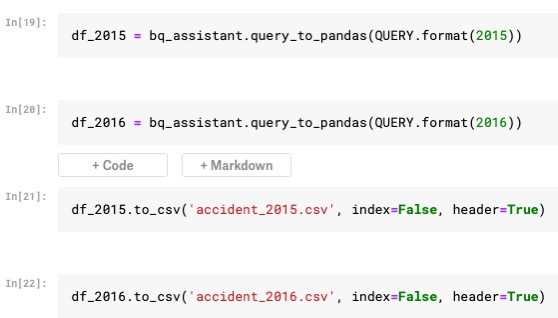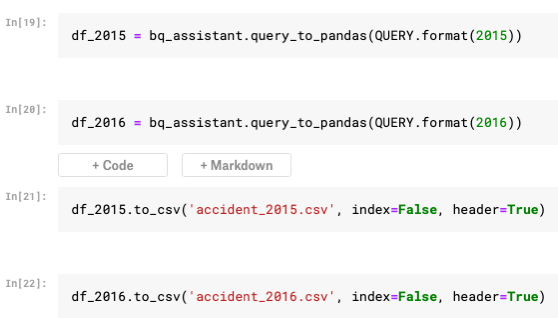
**NOTE:** Each table contains one year of data and the dataset covered 2015 and 2016 data. Two files were extracted for each table.


## Data Quality
The “manner_of_collision_name” column of the “Accident” table is a string field that contained embedded end of line characters. These extra end of line characters positioned prior to the true end of the line caused parsing errors when the csv file was loaded.

### Resolution
The Accident data was searched to ensure it contained no ‘~’ characters so that this character could be used as the true delimiter for lines during the initial data extraction. The original extraction select statement was rerun to include a hardcoded ‘~’ character at the beginning of each line as shown below:

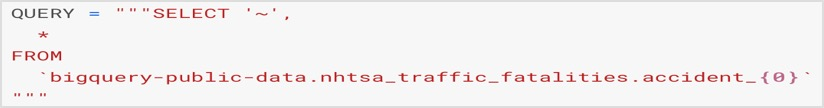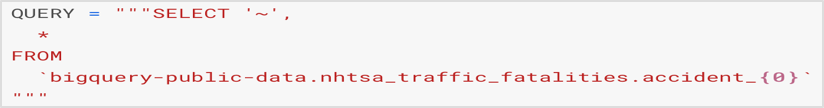

The UNIX “translate” command line tool was then used to delete all end of line characters in the newly extracted data file. After running this command, the file was left as one long string of characters, with ‘~’ separating the lines. The ‘~’ characters were then replaced with an actual end of line character. The extraneous field created by the ‘~’ at the beginning of each line was cut from the result. The complete command is shown below: 

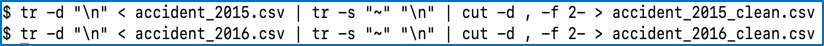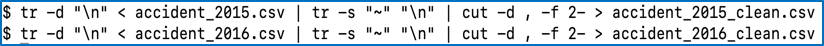

## Data Exploration
What follows is the Python source code used to explore the data.

We start by importing the required packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Then we use pandas to read in each file and concatenate them into one Dataframe.

In [2]:
df_2015 = pd.read_csv("./data/accident_2015_clean.csv", parse_dates=['timestamp_of_crash'])
df_2016 = pd.read_csv("./data/accident_2016_clean.csv", parse_dates=['timestamp_of_crash'])

In [3]:
accidentData = pd.concat([df_2015, df_2016])

In [4]:
len(accidentData) == len(df_2015)+ len(df_2016)

True

In [5]:
len(accidentData)

67286

### 1.	WHICH DAYS HAVE A HIGHER PERCENTAGE OF FATAL CRASHES?

In this dataset, days are defined as: 1 Sunday, 2 Monday, 3 Tuesday, 4 Wednesday, 5 Thursday, 6 Friday, 7 Saturday.

The query results show that Saturday, Sunday, and Friday (weekends) are the worst days for crashes.


In [6]:
crashes_all = accidentData.groupby("day_of_week").size().sort_values(ascending=False)
crashes_all

day_of_week
7    11818
1    10651
6    10313
5     9166
4     8621
2     8575
3     8142
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

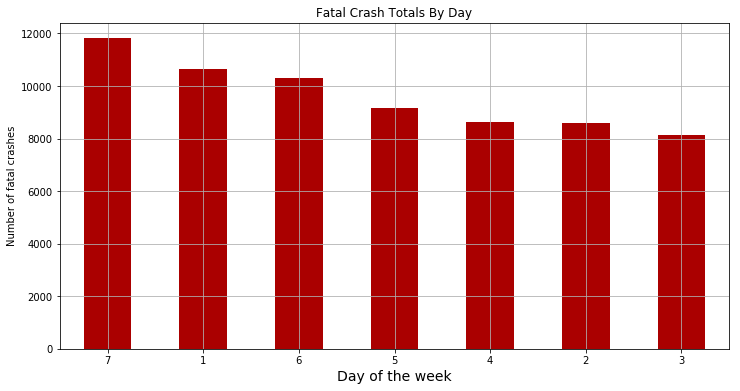

In [7]:
plt.figure(figsize=(12,6))
Chart = crashes_all.plot(kind="bar", facecolor="#AA0000", title="Fatal Crash Totals By Day", grid=True)
Chart.set_xlabel('Day of the week', fontsize=14)
Chart.set_ylabel('Number of fatal crashes');
plt.xticks(rotation=0)

### 2.	ARE THERE ANY STATES THAT RUN COUNTER TO THIS TREND?

In this query, we want to list all states that have at least one weekday as one of the top 3 worst days for crashes, which would run counter to the previous finding. So we will be looking specifically at the top 3 days and checking to see if a day number other than 1 (Sunday), 6 (Friday), or 7 (Saturday) appears. 

We start by grouping getting the counts for each state.

In [8]:
accidentData_agg = accidentData.groupby(["state_name","day_of_week"]).agg({"state_name":"count"})
accidentData_agg

state_name
state_name    day_of_week            
Alabama       1                   283
              2                   211
              3                   216
              4                   214
              5                   253
              6                   280
              7                   306
Alaska        1                    20
              2                    15
              3                    18
              4                    18
              5                    14
              6                    26
              7                    27
Arizona       1                   251
              2                   216
              3                   208
              4                   198
              5                   229
              6                   262
              7                   303
Arkansas      1                   140
              2                   156
              3                   119
              4                   131
              5                   156
              6                   147
              7                   146
California    1                  1078
              2                   856
...                               ...
Virginia      6                   216
              7                   250
Washington    1                   159
              2                   124
              3                   131
              4                   134
              5                   130
              6                   155
              7                   170
West Virginia 1                    65
              2                    56
              3                    64
              4                    85
              5                    74
              6                    80
              7                    72
Wisconsin     1                   164
              2                   138
              3                   127
              4                   130
              5                   135
              6                   152
              7                   221
Wyoming       1                    32
              2                    31
              3                    32
              4                    30
              5                    34
              6                    28
              7                    42

[357 rows x 1 columns]

Next we need to get the top three days for crashes for each state.

In [9]:
accidentData_group_lvl0 = accidentData_agg["state_name"].groupby(level=0, group_keys=False)
accidentData_group_lvl0

In [10]:
accidentData_group_res = accidentData_group_lvl0.apply(lambda x: x.sort_values(ascending=False).head(3))
accidentData_group_res
# accidentData_group_lvl0.nlargest(3)

state_name            day_of_week
Alabama               7               306
                      1               283
                      6               280
Alaska                7                27
                      6                26
                      1                20
Arizona               7               303
                      6               262
                      1               251
Arkansas              5               156
                      2               156
                      6               147
California            7              1169
                      1              1078
                      6              1034
Colorado              7               178
                      1               178
                      6               168
Connecticut           7               101
                      1                93
                      6                92
Delaware              7                54
                      6                37


Next we need to apply a filter so that only the states running counter to the national trend remains.

In [11]:
idx = pd.IndexSlice
accidentData_group_res_counter = accidentData_group_res.loc[idx[:, [2,3,4,5]]]
accidentData_group_res_counter

state_name            day_of_week
Arkansas              5              156
                      2              156
Delaware              2               34
District of Columbia  5                8
Kentucky              5              211
Maine                 4               42
Montana               2               65
Nebraska              5               63
New Hampshire         3               34
                      2               34
New Jersey            4              161
Oregon                4              130
Rhode Island          5               20
                      2               13
Tennessee             5              274
Utah                  4               79
Vermont               2               17
West Virginia         4               85
                      5               74
Wyoming               5               34
                      3               32
Name: state_name, dtype: int64

Now we want to show the counter trend graphically.

In [12]:
accidentData_group_res_all = accidentData_group_lvl0.apply(lambda x: x.sort_values(ascending=False))
RhodeIsland_data = accidentData_group_res_all['Rhode Island']
custom_dict = {7:0, 1:1, 6:2, 5:3, 4:4, 2:5, 3:6}
RhodeIsland_data_sorted = RhodeIsland_data.iloc[RhodeIsland_data.index.map(custom_dict).argsort()]
RhodeIsland_data_sorted

day_of_week
7    12
1    14
6     9
5    20
4    11
2    13
3    10
Name: state_name, dtype: int64

Normalize the data before plotting.

In [13]:
sum1 = np.sum(RhodeIsland_data_sorted.values)
RhodeIsland_data_normalized = np.divide(RhodeIsland_data_sorted.values, sum1)

sum2 = np.sum(crashes_all.values)
crashes_all_normalized = np.divide(crashes_all.values, sum2)

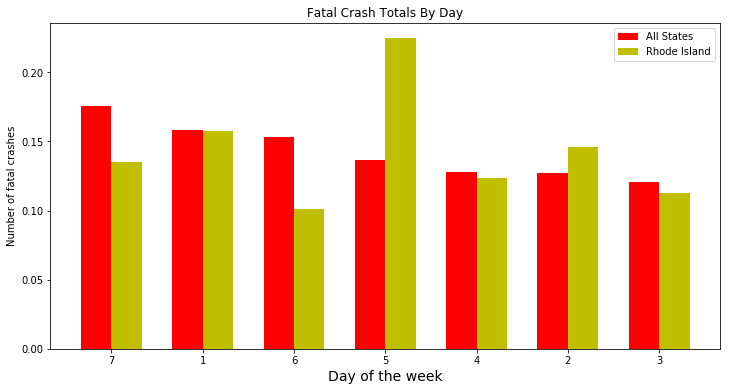

In [14]:
indices = range(len(crashes_all.index.values))
width = np.min(np.diff(indices))/3

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(indices, crashes_all_normalized, width, color='r')
rects2 = ax.bar(indices + width, RhodeIsland_data_normalized, width, color='y')

ax.set_xlabel('Day of the week', fontsize=14)
ax.set_ylabel('Number of fatal crashes');
ax.set_title("Fatal Crash Totals By Day");
ax.set_xticks(indices + width / 2)
ax.axes.set_xticklabels(crashes_all.index.values);

ax.legend((rects1[0], rects2[0]), ('All States', 'Rhode Island'))

### 3.	WHICH TIME  HAS A HIGHER PERCENTAGE OF CRASHES?

In this dataset, the hour of the crash is reported in military time as 00-23. A value of 99, which will be filtered from the calculation, represents ‘Not Applicable’, ‘Not Notified’, or ‘Unknown’. The hour of the crash is the 17th column in the table. 

The query results show that the worst times for crashes range broadly between 5 and 9 PM.


In [15]:
crashes_hours_all = accidentData[accidentData.hour_of_crash != 99].groupby("hour_of_crash").size().sort_values(ascending=False)
crashes_hours_all

hour_of_crash
18    3899
20    3802
17    3769
19    3705
21    3628
16    3469
15    3428
22    3216
14    3091
13    2908
23    2829
0     2631
2     2573
12    2545
1     2509
6     2495
11    2370
7     2295
5     2158
10    2043
3     1980
9     1957
8     1882
4     1603
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

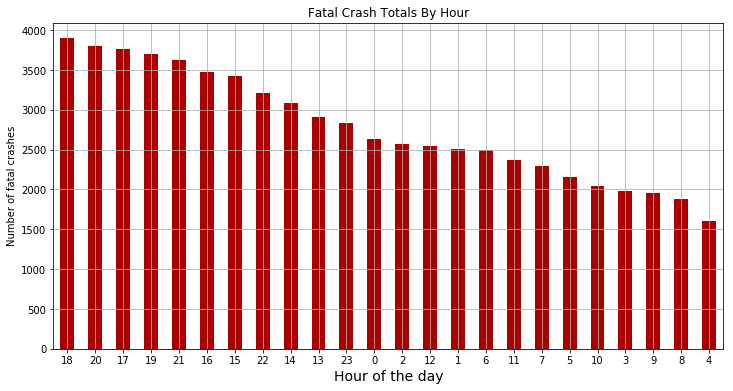

In [16]:
plt.figure(figsize=(12,6))
Chart = crashes_hours_all.plot(kind="bar", facecolor="#AA0000", title="Fatal Crash Totals By Hour", grid=True)
Chart.set_xlabel('Hour of the day', fontsize=14)
Chart.set_ylabel('Number of fatal crashes');
plt.xticks(rotation=0)

### 4.	ARE THERE ANY STATES THAT RUN COUNTER TO THIS TREND?

In this query, we want to list all states that have their highest crash rate at times other than between 5 and 9 PM, running counter to the nationwide trend. We will approach this by identifying the states whose top two crash hours do not match any of the top 4 crash hours from the overall population. When we looked at the data without regard to state, the top 4 crash hours were 17, 18, 19, and 20. Here we will be looking for the states whose top 2 crash hours do not match any of 17, 18, 19, and 20.

We start by grouping getting the counts for each state.

In [17]:
accidentData_agg = accidentData[accidentData.hour_of_crash != 99].groupby(["state_name","hour_of_crash"]).agg({"state_name":"count"})
accidentData_group_lvl0 = accidentData_agg["state_name"].groupby(level=0, group_keys=False)
accidentData_group_res = accidentData_group_lvl0.nlargest(2)
accidentData_group_res

state_name            hour_of_crash
Alabama               20               103
                      19               101
Alaska                14                12
                      18                10
Arizona               20               115
                      19               109
Arkansas              17                81
                      16                65
California            20               428
                      18               426
Colorado              17                74
                      19                64
Connecticut           17                35
                      22                33
Delaware              1                 18
                      21                18
District of Columbia  1                  5
                      2                  5
Florida               20               396
                      21               388
Georgia               15               163
                      18               160
Hawaii            

Next we need to get top two hours that are NOT 17, 18, 19 or 20 for each state, and grab the states whose top two crash hours do not match any of the top 4 crash hours from the overall population.

In [18]:
accidentData_group_res_filtered = accidentData_group_res[~accidentData_group_res.index.isin([17,18,19,20], level=1)]
accidentData_group_res_filtered

state_name            hour_of_crash
Alaska                14                12
Arkansas              16                65
Connecticut           22                33
Delaware              1                 18
                      21                18
District of Columbia  1                  5
                      2                  5
Florida               21               388
Georgia               15               163
Idaho                 16                29
Illinois              16               125
                      15               112
Indiana               21                93
Iowa                  15                39
Kansas                16                53
                      14                44
Kentucky              15                91
Louisiana             21                85
Maine                 14                20
Maryland              21                56
Massachusetts         15                44
Michigan              21               117
Minnesota         

In [19]:
accidentData_group_res_counts = accidentData_group_res_filtered.groupby("state_name").size()

In [20]:
accidentData_group_res_counts = accidentData_group_res_counts[accidentData_group_res_counts[:] == 2]
accidentData_group_res_counts

state_name
Delaware                2
District of Columbia    2
Illinois                2
Kansas                  2
Minnesota               2
Montana                 2
Rhode Island            2
South Dakota            2
Vermont                 2
West Virginia           2
Name: state_name, dtype: int64

Now we want to show the counter trend graphically.
First we want to match the sort from the nationwide trend.

In [21]:
accidentData_group_res_all = accidentData_group_lvl0.apply(lambda x: x.sort_values(ascending=False))
Delaware_data = accidentData_group_res_all.Delaware
custom_dict = {18:0, 20:1, 17:2, 19:3, 21:4, 16:5, 15:6, 22:7, 14:8, 13:9, 23:10, 0:11, 2:12, 12:13, 1:14, 6:15, 11:16, 7:17, 5:18, 10:19, 3:20, 9:21, 8:22, 4:23}
Delaware_data_sorted = Delaware_data.iloc[Delaware_data.index.map(custom_dict).argsort()]
Delaware_data_sorted

hour_of_crash
18    10
20    16
17    16
19    15
21    18
16    11
15    12
22    14
14     9
13    14
23     9
0     13
2     11
12     7
1     18
6      6
11     6
7     10
5      7
10     7
3      4
9      1
8      2
4      7
Name: state_name, dtype: int64

Before plotting, we need to normalize the data.

In [22]:
sum1 = np.sum(Delaware_data_sorted.values)
Delaware_data_normalized = np.divide(Delaware_data_sorted.values, sum1)

sum2 = np.sum(crashes_hours_all.values)
crashes_hours_all_normalized = np.divide(crashes_hours_all.values, sum2)

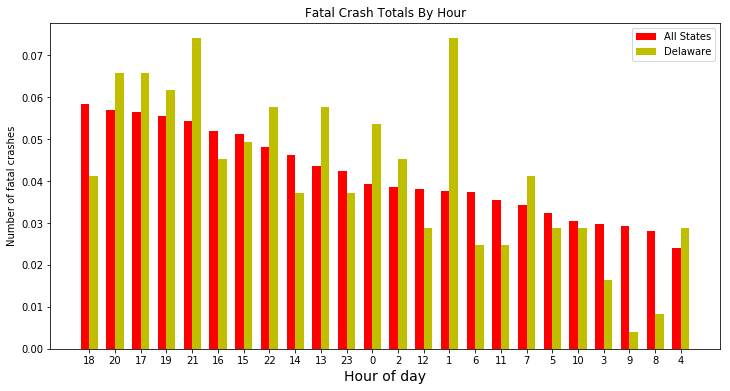

In [23]:
indices = range(len(crashes_hours_all.index.values))
width = np.min(np.diff(indices))/3

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(indices, crashes_hours_all_normalized, width, color='r')
rects2 = ax.bar(indices + width, Delaware_data_normalized, width, color='y')

ax.set_xlabel('Hour of day', fontsize=14)
ax.set_ylabel('Number of fatal crashes');
ax.set_title("Fatal Crash Totals By Hour");
ax.axes.set_xticklabels(crashes_hours_all.index.values);
ax.set_xticks(indices + width / 2)

ax.legend((rects1[0], rects2[0]), ('All States', 'Delaware'))

### 5.	WHICH LAND USE INDICATORS HAVE A HIGHER PERCENTAGE OF CRASHES?

The “Land Use” data indicates if the accident occurred in a rural or urban area of the country. The valid values found in the “land_use_name” field include: "Rural" and "Urban". The following values in this column are considered bad data and will be filtered: "Trafficway Not in State Inventory", "Not Reported", and "Unknown". The “land_use_name” field is the 21th column in the table.

The data does not show a significant difference between totals for Urban and Rural.


In [24]:
#accidentData.filter("land_use_name != 'Unknown' and land_use_name != 'Not Reported' and land_use_name != 'Trafficway Not in State Inventory'").groupBy("land_use_name").count().sort(desc("count")).show
crashes_by_landuse_all = accidentData[(accidentData.land_use_name != 'Unknown') & (accidentData.land_use_name != 'Not Reported') & (accidentData.land_use_name != 'Trafficway Not in State Inventory')].groupby("land_use_name").size().sort_values(ascending=False)
crashes_by_landuse_all

land_use_name
Urban    34660
Rural    32322
dtype: int64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

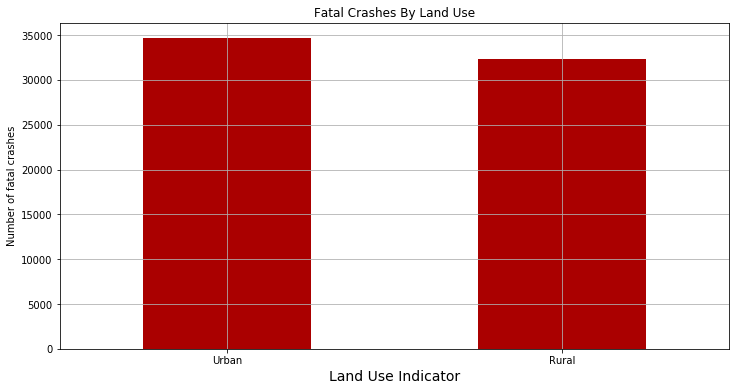

In [25]:
plt.figure(figsize=(12,6))
Chart = crashes_by_landuse_all.plot(kind="bar", facecolor="#AA0000", title="Fatal Crashes By Land Use", grid=True)
Chart.set_xlabel('Land Use Indicator', fontsize=14)
Chart.set_ylabel('Number of fatal crashes');
plt.xticks(rotation=0)

### 6.	ARE THERE ANY STATES THAT RUN COUNTER TO THIS TREND?

In this query, we want to list all states that show a higher rate of fatal crashes in rural areas, running counter to the nationwide trend.


In [26]:
accidentData_agg = accidentData[(accidentData.land_use_name != 'Unknown') & (accidentData.land_use_name != 'Not Reported') & (accidentData.land_use_name != 'Trafficway Not in State Inventory')].groupby(["state_name","land_use_name"]).agg({"state_name":"count"})
accidentData_group_lvl0 = accidentData_agg["state_name"].groupby(level=0, group_keys=False)
accidentData_group_res = accidentData_group_lvl0.nlargest(1)
accidentData_group_res

state_name            land_use_name
Alabama               Rural            1248
Alaska                Rural              76
Arizona               Urban            1092
Arkansas              Rural             669
California            Urban            3999
Colorado              Urban             594
Connecticut           Urban             458
Delaware              Rural             126
District of Columbia  Urban              48
Florida               Urban            3982
Georgia               Urban            1700
Hawaii                Urban             157
Idaho                 Rural             339
Illinois              Urban            1142
Indiana               Rural             980
Iowa                  Rural             462
Kansas                Rural             533
Kentucky              Rural            1086
Louisiana             Urban             728
Maine                 Rural             240
Maryland              Urban             728
Massachusetts         Urban             

In [27]:
accidentData_group_res.loc[:,'Rural']

state_name
Alabama           1248
Alaska              76
Arkansas           669
Delaware           126
Idaho              339
Indiana            980
Iowa               462
Kansas             533
Kentucky          1086
Maine              240
Minnesota          451
Mississippi        975
Missouri           957
Montana            334
Nebraska           289
New Hampshire      128
New Mexico         358
North Carolina    1668
North Dakota       198
Oklahoma           730
Oregon             524
Pennsylvania      1149
South Carolina    1075
South Dakota       186
Vermont             90
Virginia           902
West Virginia      334
Wisconsin          690
Wyoming            185
Name: state_name, dtype: int64

In [28]:
accidentData_group_res_all = accidentData_group_lvl0.apply(lambda x: x.sort_values(ascending=False))
Minnesota_data = accidentData_group_res_all.Minnesota
custom_dict = {'Urban':0, 'Rural':1}
Minnesota_data_sorted = Minnesota_data.iloc[Minnesota_data.index.map(custom_dict).argsort()]
Minnesota_data_sorted

land_use_name
Urban    278
Rural    451
Name: state_name, dtype: int64

In [29]:
sum1 = np.sum(Minnesota_data_sorted.values)
Minnesota_data_normalized = np.divide(Minnesota_data_sorted.values, sum1)

sum2 = np.sum(crashes_by_landuse_all.values)
crashes_by_landuse_normalized = np.divide(crashes_by_landuse_all.values, sum2)

In [30]:
indices = range(len(crashes_by_landuse_all.index.values))
width = np.min(np.diff(indices))/3
indices + width

array([0.33333333, 1.33333333])

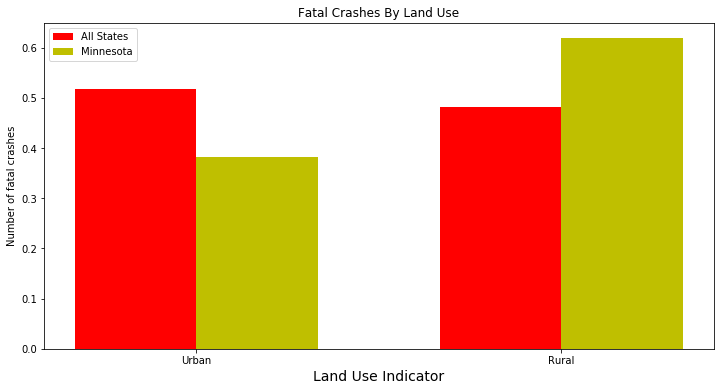

In [31]:
indices = range(len(crashes_by_landuse_all.index.values))
width = np.min(np.diff(indices))/3

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(indices, crashes_by_landuse_normalized, width, color='r')
rects2 = ax.bar(indices + width, Minnesota_data_normalized, width, color='y')

ax.set_xlabel('Land Use Indicator', fontsize=14)
ax.set_ylabel('Number of fatal crashes');
ax.set_title("Fatal Crashes By Land Use");
ax.axes.set_xticklabels(crashes_by_landuse_all.index.values);
ax.set_xticks(indices + width / 2)
ax.legend((rects1[0], rects2[0]), ('All States', 'Minnesota'))